# Credit Card Fraud Detection
This notebook is dedicated to the deployment of XGBoost on our processed dataset.

### Imports and Globals

In [1]:
import sys
sys.path.append('../utils')

import warnings
import pandas as pd
from utils import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

FILENAME = 'data/creditcard.csv'
MODEL_DIR = 'models/'

In [2]:
df = pd.read_csv(FILENAME)
df[['Time', 'Amount']] = StandardScaler().fit_transform(df[['Time', 'Amount']])

In [3]:
print('Size of dataset: {} samples'.format(len(df)))
class_distribution(df)

Size of dataset: 284807 samples
% dataset with class 0: 99.83%
% dataset with class 1: 0.17%



### Train and Testsets
***
Before balancing the data, I will be splitting it into a training set and a testing set. The test set should come from the original distribution, so we use train_test_split and stratify based on the class distribution.

**holdout_df** will contain the test samples and will not be touched outside model evaluation later.

In [4]:
X = df.drop(labels=['Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
holdout_df = pd.concat([X_test, y_test], axis=1)

print('TRAINING SET')
print('- Fraud class size: {}\n- Non-Fraud class size: {}'.format(len(train_df[train_df.Class == 1]), len(train_df[train_df.Class == 0])))
class_distribution(train_df)

print('TESTING SET')
print('- Fraud class size: {}\n- Non-Fraud class size: {}'.format(len(holdout_df[holdout_df.Class == 1]), len(holdout_df[holdout_df.Class == 0])))
class_distribution(holdout_df)

TRAINING SET
- Fraud class size: 394
- Non-Fraud class size: 227451
% dataset with class 0: 99.83%
% dataset with class 1: 0.17%

TESTING SET
- Fraud class size: 98
- Non-Fraud class size: 56864
% dataset with class 0: 99.83%
% dataset with class 1: 0.17%



## Random Undersampling
***
The main technique employed here, we simply select an equal number of non-fraud samples as we do fraud samples. 

Performing random undersampling! Just randomly choose equal portion non-fraud samples and fraud samples. Since there are more non-fraud samples, we only have to portion down this field, and we keep all the fraud-samples.

In [5]:
balanced_df = train_df.groupby('Class', group_keys=False).apply(lambda x: x.sample(len(train_df[train_df.Class == 1])))

### Data Preprocessing
***
Now that we have our balanced dataset for training. We should also look into outlier detection and removal. I've created some simple utility functions to do the outlier removal, all we need is to set a minimum value for the correlation.
- This will remove all the datapoints that fall outside some inner-range of the data's distribution. 
- The threshold we use is 1.5, giving bounds:
    - lower_bound = lower_quartile - threshold * interquartile_range
    - upper_bound = upper_quartile + threshold * interquartile_range

In [6]:
corr_feats = get_high_corr_feats(balanced_df, min_val=0.65)
trimmed_df = trim_feature_outliers(balanced_df, feats=corr_feats.index, threshold=1.4, summary=False)

Features Strongly Correlated with Class
V4 0.7170118841000078
V11 0.6927196355877747
V12 0.6861813143781497
V14 0.7411488015606598


### Model Selection and Training
***
For deployment, we will try to train XGBoost, which is a decision tree classifier using gradient boosting. It is well aligned with this task, especially with the good performance we found in the exploratory notebook using Random Forest.

##### Imports and Helper Functions

In [7]:
from xgboost import XGBClassifier

##### Model Training and Evaluation

This is our model, a gradient boosted tree classifier!

In [8]:
xgb = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

After evaluation we can see this algorithm performs even better than the original simple models in our exploratory notebook.

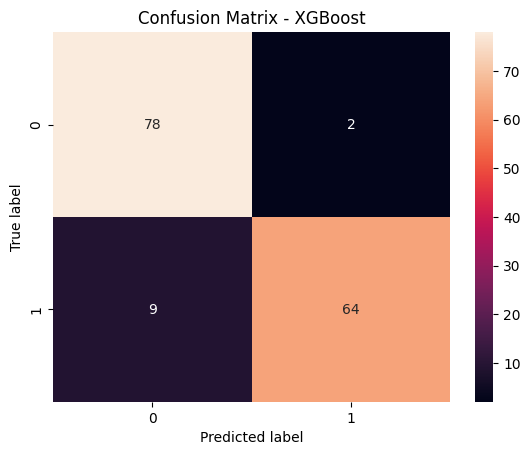

,Accuracy,Precision,Recall,AUC-ROC
0,0.9281,0.9697,0.8767,0.9259


In [9]:
scores, _ = train_and_evaluate_model(xgb, trimmed_df, label='XGBoost', show_cm=True)
scores

The ROC Curve looks good too!

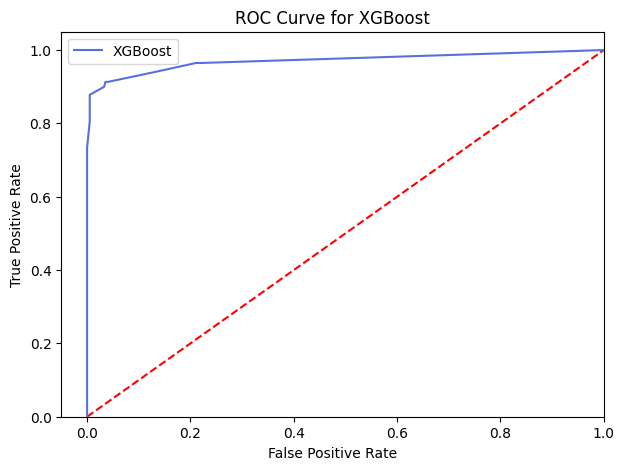

In [10]:
X = trimmed_df.drop('Class', axis=1)
y = trimmed_df['Class']

plot_roc_curve(xgb, X, y, name='XGBoost')

### Model Evaluation on Holdout Set

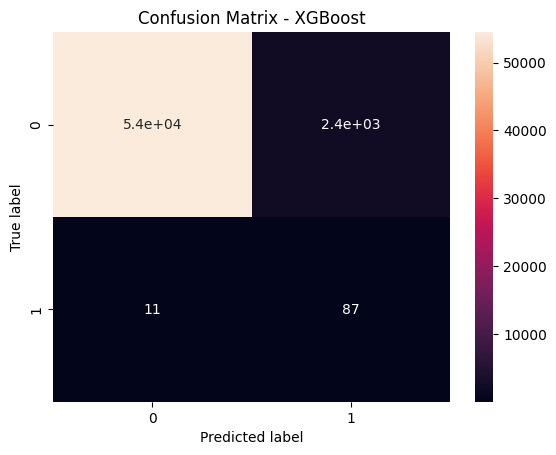

,Accuracy,Precision,Recall,AUC-ROC
0,0.9582,0.0354,0.8878,0.923


In [11]:
X_test = holdout_df.drop('Class', axis=1)
y_test = holdout_df['Class']

score, _ = evaluate_model(xgb, X_test, y_test)
score

### Save Model

In [12]:
xgb.save_model(MODEL_DIR + 'xgboost_model.model')